# Chain Of Thoughts With RAG

What is Chain-of-Thought (CoT) in RAG?

CoT reasoning breaks down a complex question into intermediate steps, and allows retrieval + reflection at each step before answering.

User Query
   ↓
- Step 1: Decompose question → sub-steps (Reason)
- Step 2: Retrieve docs per step (Act)
- Step 3: Combine context (Observe)
- Step 4: Final answer generation (Reflect)

## Setup and Import Libraries

In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings
from langchain.chat_models import init_chat_model
from langchain_community.document_loaders import TextLoader
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, END
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [ ]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [ ]:
embedding = OpenAIEmbeddings()
llm = init_chat_model("openai:gpt-4o")

## Document Loading and Text Splitting

In [5]:
documents = TextLoader(
    file_path="research_notes.txt", encoding="utf-8"
).load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500, chunk_overlap=50
)

chunks = text_splitter.split_documents(documents=documents)

## Create Vector Store Retriever

In [6]:
vector_store = FAISS.from_documents(
    documents=chunks,
    embedding=embedding
)

retriever = vector_store.as_retriever()

## LangGraph State Definition

In [7]:
class RAGCotState(BaseModel):
    question: str
    sub_steps: List[str] = []
    retrieved_documents: List[Document] = []
    answer: str = ""

## Nodes

### Plan Sub Questions

In [8]:
def plan_steps(state:RAGCotState) -> RAGCotState:
    prompt = f"Break the question into 2-3 reasoning steps: \n\n {state.question}"
    result = llm.invoke(input=prompt).content

    sub_questions = [line.strip("-") for line in result.split("\n") if line.strip]

    return state.model_copy(update={"sub_steps":sub_questions})

### Retrieve Each Step

In [9]:
def retrieve_per_step(state:RAGCotState) -> RAGCotState:
    documents = []
    for step in state.sub_steps:
        document = retriever.invoke(input=step)
        documents.extend(document)

    return state.model_copy(update={"retrieved_documents": documents})

### Generate Final Answer

In [16]:
def generate_answer(state:RAGCotState) -> RAGCotState:
    context = "\n\n".join(document.page_content for document in state.retrieved_documents)
    
    prompt = f""" 
    You are answering a complex question using reasoning and retrieved documents.

    Question: {state.question}

    Relevant Information:
    {context}

    Now synthesize a well-reasoned final answer.
    """
    
    result = llm.invoke(input=prompt).content.strip()
    return state.model_copy(update={"answer": result})

## Create Graph

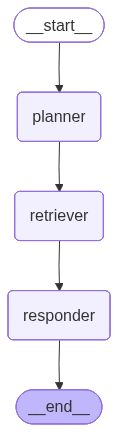

In [17]:
graph = StateGraph(RAGCotState)

## Add Nodes
graph.add_node(node="planner", action=plan_steps)
graph.add_node(node="retriever", action=retrieve_per_step)
graph.add_node(node="responder", action=generate_answer)

## Set Entry Point
graph.set_entry_point(key="planner")

## Add Edges
graph.add_edge(start_key="planner", end_key="retriever")
graph.add_edge(start_key="retriever", end_key="responder")
graph.add_edge(start_key="responder", end_key=END)

## Compile Graph
compiled_graph = graph.compile()

## Display Graph
compiled_graph

## Query

In [19]:
query = "what are the additional eperiments in Transformer eveluation?"

state = RAGCotState(question=query)
final = compiled_graph.invoke(state)

print("\n🪜 Reasoning Steps:", final["sub_steps"])
print("\n✅ Final Answer:\n", final["answer"])


🪜 Reasoning Steps: ['To evaluate Transformers more comprehensively, you can consider breaking the question into the following reasoning steps:', '', '1. **Identify Core Evaluation Metrics and Goals:**', '   - What are the primary objectives of evaluating a Transformer model? This typically includes understanding performance in terms of accuracy, efficiency, and generalization across different tasks.', '', '2. **Determine Additional Experimental Setups:**', '   - What additional experiments can provide deeper insights into Transformer capabilities? This could involve:', '     - **Ablation Studies:** Evaluating the impact of removing or altering different components of the model to understand their contributions.', "     - **Hyperparameter Tuning:** Exploring different configurations to optimize performance and identify which parameters significantly impact the model's success.", "     - **Robustness Testing:** Assessing the model's ability to handle noise, adversarial attacks, or domai